# Classifier analysis

In this notebook, I find the precision&ndash;recall and ROC curves of classifiers, and look at some examples of where the classifiers do really well (and really poorly).

In [29]:
import csv
import sys

import astropy.wcs
import h5py
import matplotlib.pyplot as plot
import numpy
import sklearn.metrics

sys.path.insert(1, '..')
import crowdastro.train

CROWDASTRO_H5_PATH = '../crowdastro.h5'
CROWDASTRO_CSV_PATH = '../crowdastro.csv'
TRAINING_H5_PATH = '../training.h5'
ARCMIN = 1 / 60

%matplotlib inline

## Logistic regression

### Precision&ndash;recall and ROC curves

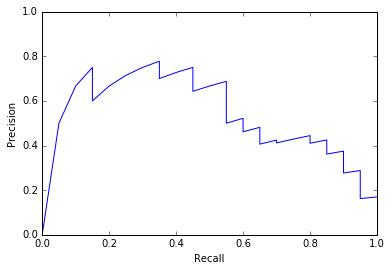

Accuracy: 86.95%


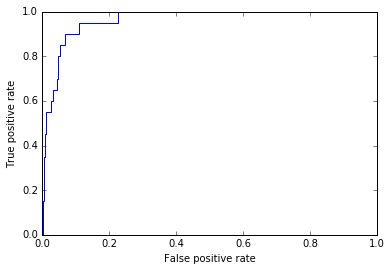

In [4]:
with h5py.File(CROWDASTRO_H5_PATH) as crowdastro_h5:
    with h5py.File(TRAINING_H5_PATH) as training_h5:
        classifier, astro_t, image_t = crowdastro.train.train(
                crowdastro_h5, training_h5, '../classifier.pkl', '../astro_transformer.pkl',
                '../image_transformer.pkl', classifier='lr')
        
        testing_indices = crowdastro_h5['/atlas/cdfs/testing_indices'].value
        all_astro_inputs = astro_t.transform(training_h5['astro'].value)
        all_cnn_inputs = image_t.transform(training_h5['cnn_outputs'].value)
        all_inputs = numpy.hstack([all_astro_inputs, all_cnn_inputs])
        all_labels = training_h5['labels'].value
        
        inputs = all_inputs[testing_indices]
        labels = all_labels[testing_indices]
        probs = classifier.predict_proba(inputs)
        
        precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, probs[:, 1])
        plot.plot(recall, precision)
        plot.xlabel('Recall')
        plot.ylabel('Precision')
        plot.show()
        
        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, probs[:, 1])
        plot.plot(fpr, tpr)
        plot.xlabel('False positive rate')
        plot.ylabel('True positive rate')
        
        print('Accuracy: {:.02%}'.format(classifier.score(inputs, labels)))

### Confident, but wrong classifications

In [22]:
max_margin = float('-inf')
max_index = None
max_swire = None
with h5py.File(CROWDASTRO_H5_PATH) as crowdastro_h5:
    with h5py.File(TRAINING_H5_PATH) as training_h5:
        classifier, astro_t, image_t = crowdastro.train.train(
                crowdastro_h5, training_h5, '../classifier.pkl', '../astro_transformer.pkl',
                '../image_transformer.pkl', classifier='lr')
        
        testing_indices = crowdastro_h5['/atlas/cdfs/testing_indices'].value
        swire_positions = crowdastro_h5['/swire/cdfs/catalogue'][:, :2]
        atlas_positions = crowdastro_h5['/atlas/cdfs/positions'].value
        all_astro_inputs = training_h5['astro'].value
        all_cnn_inputs = training_h5['cnn_outputs'].value
        all_labels = training_h5['labels'].value

        swire_tree = sklearn.neighbors.KDTree(swire_positions, metric='chebyshev')

        simple = True
        if simple:
            atlas_counts = {}  # ATLAS ID to number of objects in that subject.
            for consensus in crowdastro_h5['/atlas/cdfs/consensus_objects']:
                atlas_id = int(consensus[0])
                atlas_counts[atlas_id] = atlas_counts.get(atlas_id, 0) + 1

            indices = []
            for atlas_id, count in atlas_counts.items():
                if count == 1 and atlas_id in testing_indices:
                    indices.append(atlas_id)

            indices = numpy.array(sorted(indices))

            atlas_positions = atlas_positions[indices]
            print('Found %d simple subjects.', len(atlas_positions))
        else:
            atlas_positions = atlas_positions[testing_indices]
            print('Found %d subjects.', len(atlas_positions))

        # Test each ATLAS subject.
        n_correct = 0
        n_total = 0
        for atlas_index, pos in enumerate(atlas_positions):
            neighbours, distances = swire_tree.query_radius([pos], ARCMIN,
                                                            return_distance=True)
            neighbours = neighbours[0]
            distances = distances[0]

            astro_inputs = all_astro_inputs[neighbours]
            astro_inputs[:, -1] = distances
            cnn_inputs = all_cnn_inputs[neighbours]
            labels = all_labels[neighbours]

            features = []
            features.append(astro_t.transform(astro_inputs))
            features.append(image_t.transform(cnn_inputs))
            
            inputs = numpy.hstack(features)
            outputs = classifier.predict_proba(inputs)[:, 1]
            assert len(labels) == len(outputs)
            index = outputs.argmax()
            correct = labels[index] == 1
            
            if not correct:
                outputs.sort()
                margin = outputs[-1] - outputs[-2]
                if margin > max_margin:
                    max_margin = margin
                    max_index = atlas_index
                    max_swire = swire_positions[index]

Found %d simple subjects. 424


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


1146.01890349 6739.95367043


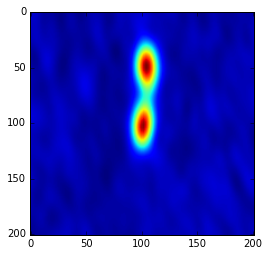

In [39]:
with h5py.File(CROWDASTRO_H5_PATH) as crowdastro_h5:
    plot.imshow(crowdastro_h5['/atlas/cdfs/images_2x2'][max_index])
    swire = crowdastro_h5['/atlas/cdfs/consensus_objects'][max_index][1]
    pos = crowdastro_h5['/swire/cdfs/catalogue'][swire][:2]
    with open(CROWDASTRO_CSV_PATH) as c_csv:
        r = csv.DictReader(c_csv)
        header = [a for a in r if int(a['index']) == max_index][0]['header']
    wcs = astropy.wcs.WCS(header)
    (x, y), = wcs.wcs_world2pix([pos], 1)
    print(x,y)

## Random forests

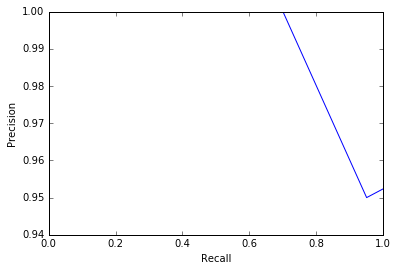

Accuracy: 99.56%


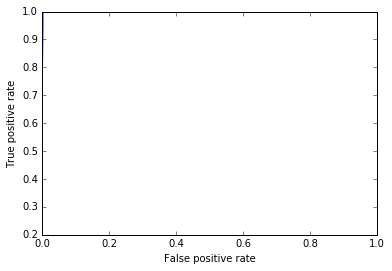

In [5]:
with h5py.File(CROWDASTRO_H5_PATH) as crowdastro_h5:
    with h5py.File(TRAINING_H5_PATH) as training_h5:
        classifier, astro_t, image_t = crowdastro.train.train(
                crowdastro_h5, training_h5, '../classifier.pkl', '../astro_transformer.pkl',
                '../image_transformer.pkl', classifier='rf')
        
        testing_indices = crowdastro_h5['/atlas/cdfs/testing_indices'].value
        all_astro_inputs = astro_t.transform(training_h5['astro'].value)
        all_cnn_inputs = image_t.transform(training_h5['cnn_outputs'].value)
        all_inputs = numpy.hstack([all_astro_inputs, all_cnn_inputs])
        all_labels = training_h5['labels'].value
        
        inputs = all_inputs[testing_indices]
        labels = all_labels[testing_indices]
        probs = classifier.predict_proba(inputs)
        
        precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, probs[:, 1])
        plot.plot(recall, precision)
        plot.xlabel('Recall')
        plot.ylabel('Precision')
        plot.show()
        
        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, probs[:, 1])
        plot.plot(fpr, tpr)
        plot.xlabel('False positive rate')
        plot.ylabel('True positive rate')
        
        print('Accuracy: {:.02%}'.format(classifier.score(inputs, labels)))